# Synthetic Control in PyMC

> Synthetic control can be considered “the most important innovation in the policy evaluation literature in the last few years” (see [The State of Applied Econometrics: Causality and Policy Evaluation](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.3) by Susan Athey and Guido W. Imbens).

In this notebook we provide an example of how to implement a synthetic control problem in [PyMC](https://github.com/pymc-devs/pymc) to answer a "what if this had happened?" type of question in the context of causal inference. We reproduce the results of the example provided in the great book [Causal Inference for The Brave and True](https://matheusfacure.github.io/python-causality-handbook/landing-page.html) by [Matheus Facure](https://matheusfacure.github.io/). Specifically, we look into the problem of estimating the *effect of cigarette taxation on its consumption* presented in Chapter [15 - Synthetic Control](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html). The purpose of this notebook is not to present a general description of this method but rather show how to implement it in PyMC. Therefore, we strongly recommend to look into the book to understand the problem, motivation and details of the method.

## Prepare Notebook

In [1]:
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Read Data

We read the data directly from the book's repository.

In [2]:
data_path = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/smoking.csv"

raw_data_df = pd.read_csv(data_path)

raw_data_df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001,False,False
2,1,1972,101.099998,9.498476,NaN,0.180994,42.299999,False,False
3,1,1973,102.900002,9.550107,NaN,0.182060,42.099998,False,False
4,1,1974,108.199997,9.537163,NaN,0.183126,43.099998,False,False


We are mainly interested in the `cigsale` variable as a target and `retprice` as control. Also note we already have an indicator tag `california` which is true for the `state` index $3$. 

In [3]:
# select relevant columns
df = raw_data_df.copy().drop(columns=["lnincome", "beer", "age15to24"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state            1209 non-null   int64  
 1   year             1209 non-null   int64  
 2   cigsale          1209 non-null   float64
 3   retprice         1209 non-null   float64
 4   california       1209 non-null   bool   
 5   after_treatment  1209 non-null   bool   
dtypes: bool(2), float64(2), int64(2)
memory usage: 40.3 KB


## EDA

Let's plot the sales data for California and the other states together. 

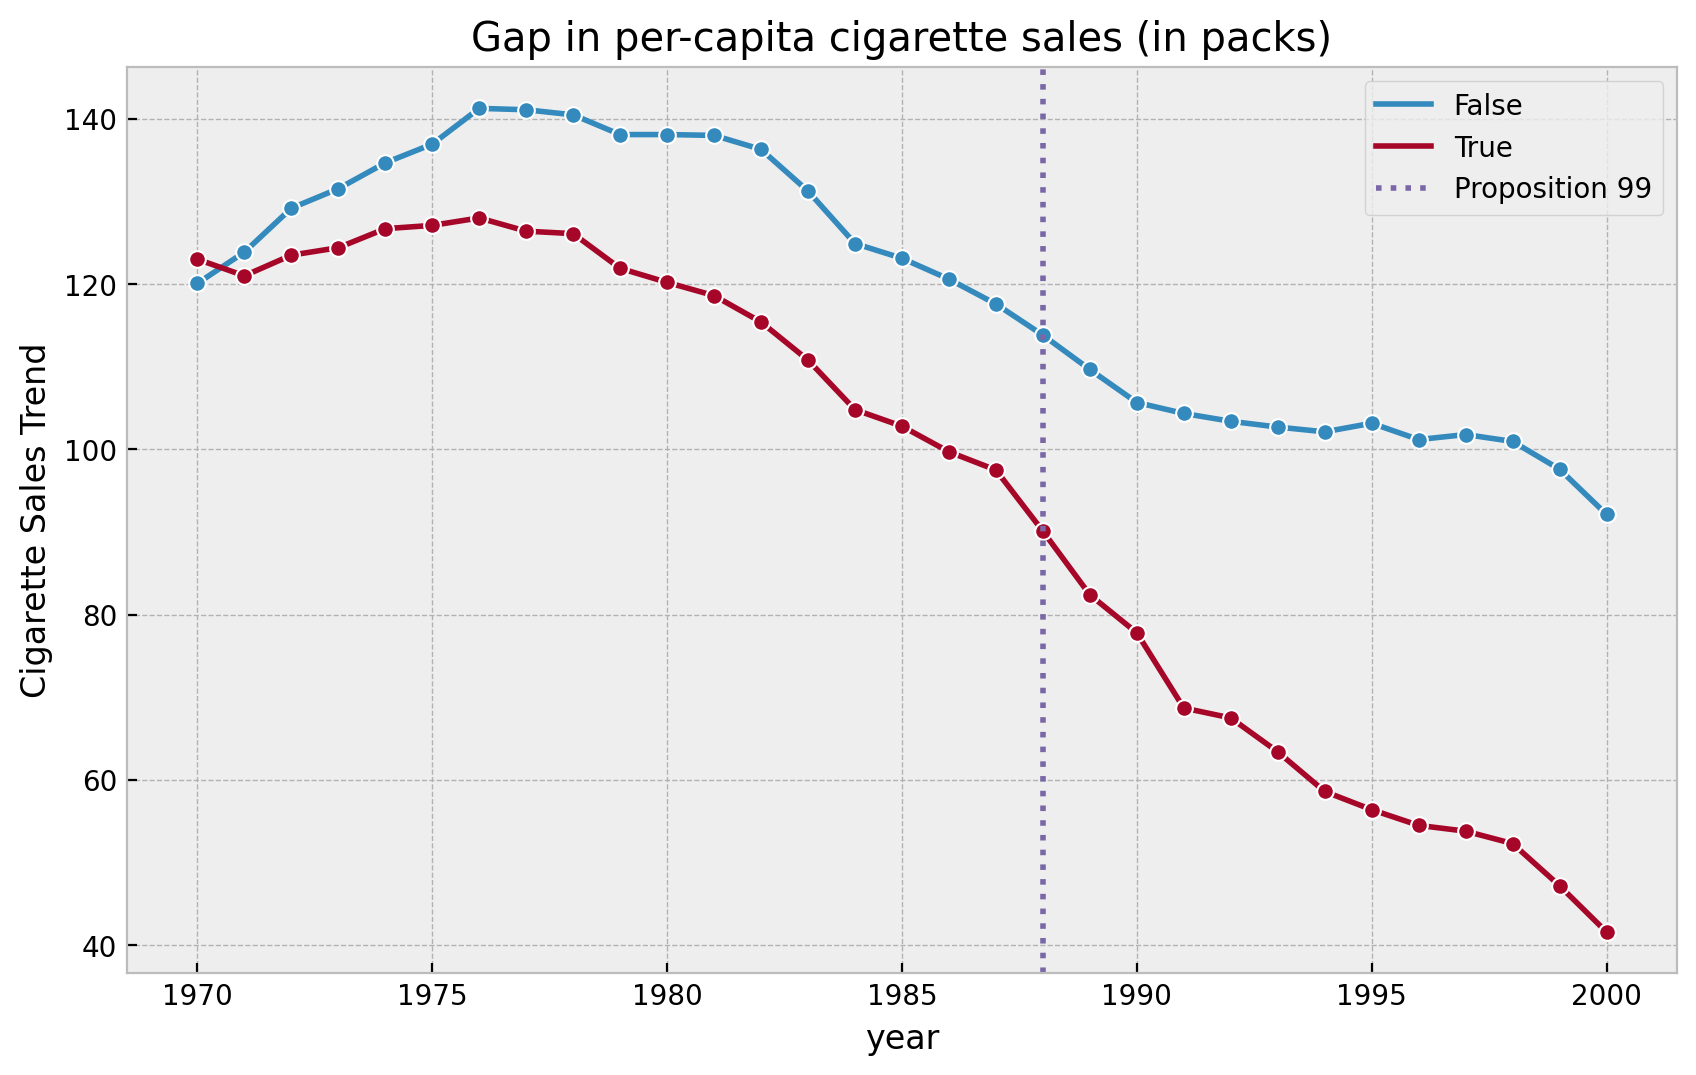

In [4]:
fig, ax = plt.subplots()

(
    df.groupby(["year", "california"], as_index=False)
    .agg({"cigsale": np.mean})
    .pipe(
        (sns.lineplot, "data"),
        x="year",
        y="cigsale",
        hue="california",
        marker="o",
        ax=ax,
    )
)
ax.axvline(
    x=1988,
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
ax.legend(loc="upper right")
ax.set(
    title="Gap in per-capita cigarette sales (in packs)", ylabel="Cigarette Sales Trend"
);


## Data Processing

We now split the data intro pre and post treatment years. Moreover, we shape the data in such a way that the columns correspond to states (see [here](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html#we-have-time) for details).

In [5]:
features = ["cigsale", "retprice"]

pre_df = (
    df
    .query("~ after_treatment")
    .pivot(index='state', columns="year", values=features)
    .T
)

post_df = (
    df
    .query("after_treatment")
    .pivot(index='state', columns="year", values=features)
    .T
)

Finally, we extract some useful information about the data.

In [6]:
idx = 3

y_pre = pre_df[idx].to_numpy()
x_pre = pre_df.drop(columns=idx).to_numpy()
pre_years = pre_df.reset_index(inplace=False).year.unique()
n_pre = pre_years.size

y_post = post_df[idx].to_numpy()
x_post = post_df.drop(columns=idx).to_numpy()
post_years = post_df.reset_index(inplace=False).year.unique()
n_post = post_years.size

k = pre_df.shape[0]

## Model

Here is the PyMC model for the synthetic control problem. The only thing to remark is the appearance of the [`Dirichlet`](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Dirichlet.html) distribution as prior for the model weights. This ensures the weights are all positive and add up all to one as required.

**Remark:** Note that the prior parameter `a` coincides with the initial point `w_start` in the `get_w(X, y)` function in the book (see [here](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html#don-t-extrapolate)).

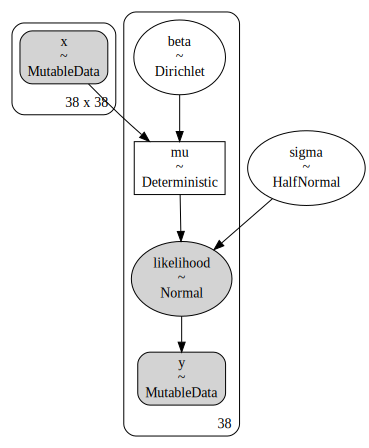

In [7]:
with pm.Model() as model:
    x = pm.MutableData(name="x", value=x_pre)
    y = pm.MutableData(name="y", value=y_pre)
    beta = pm.Dirichlet(name="beta", a=(1 / k) * np.ones(k))
    sigma = pm.HalfNormal(name="sigma", sigma=5)
    mu = pm.Deterministic(name="mu", var=pm.math.dot(x, beta))
    likelihood = pm.Normal(name="likelihood", mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(model)

We now sample from the mode to get the posterior distributions.

In [8]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:03.612764
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:16.420897
Transforming variables...
Transformation time =  0:00:00.435692
Computing Log Likelihood...
Log Likelihood time =  0:00:00.473657


100.00% [16000/16000 00:01<00:00]

Let's plot the posterior distributions for the weights.

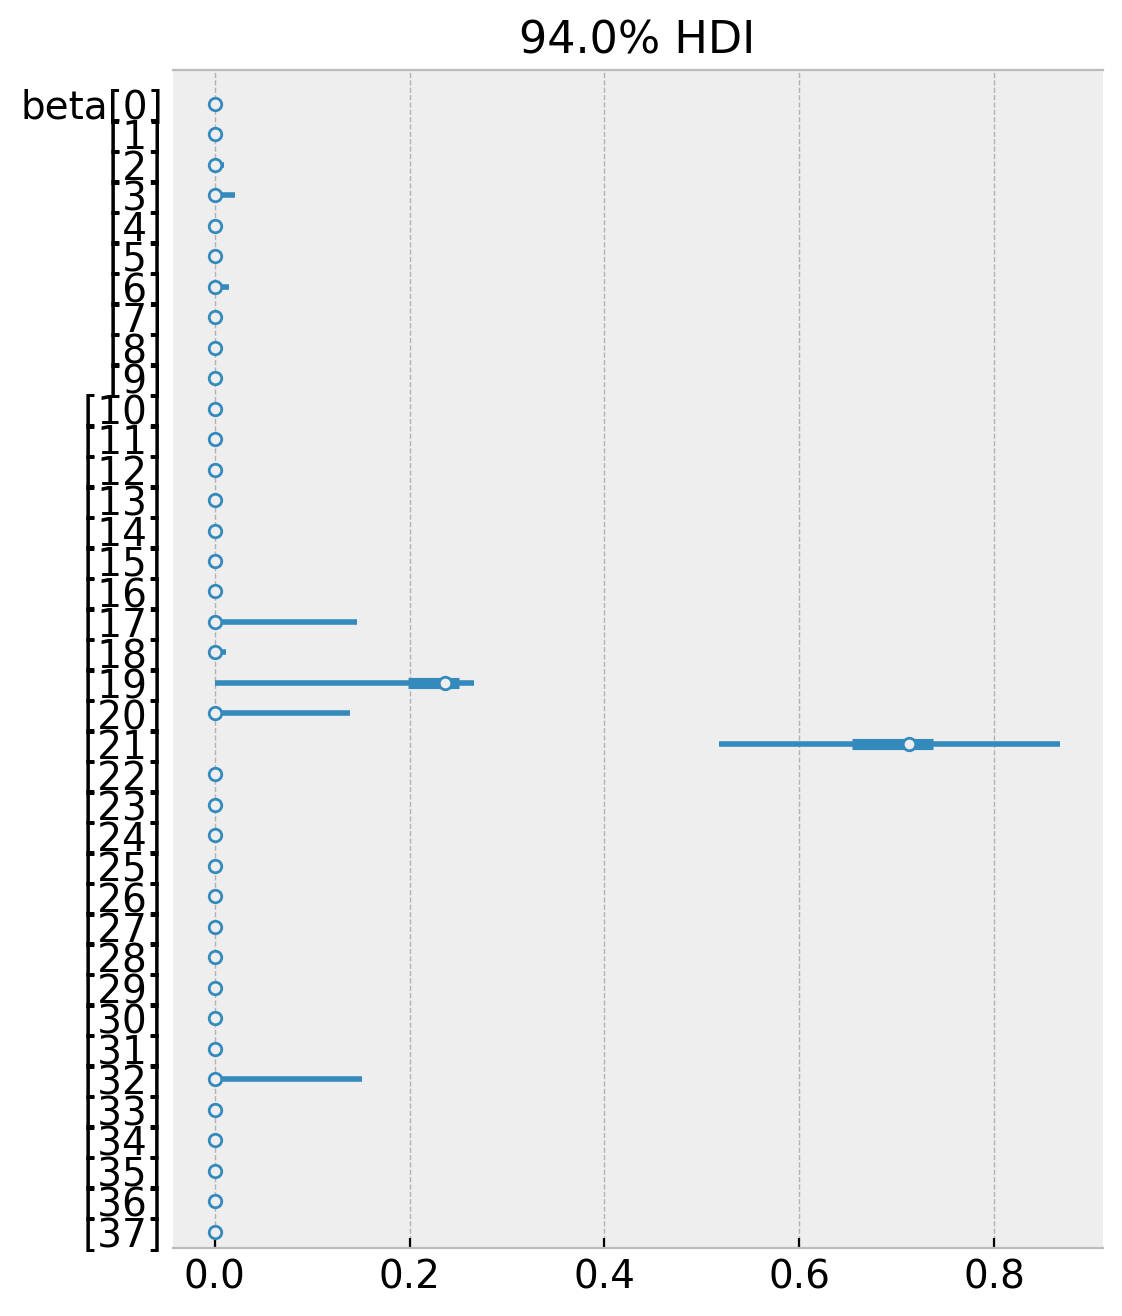

In [9]:
az.plot_forest(data=idata, combined=True, var_names=["beta"]);

Note that many of the weights are zero and the non-zero weights coincide (the mean) with the weights from the book. We can confirm that the weights satisfy the constraints, namely that they are all positive and add up to one.

In [10]:
np.unique(
    idata
    .posterior["beta"]
    .stack(samples=("chain", "draw"))
    .sum(axis=0)
    .to_numpy()
    - 1
)

array([-5.55111512e-16, -4.44089210e-16, -3.33066907e-16, -2.22044605e-16,
       -1.11022302e-16,  0.00000000e+00,  2.22044605e-16,  4.44089210e-16])

## Posterior Predictive

We can now generate predictions for the post treatment years.

In [11]:
with model:
    pm.set_data(new_data={"x": x_post, "y": y_post})
    posterior_predictive_post = pm.sample_posterior_predictive(
        trace=idata, var_names=["likelihood"]
    )


100.00% [16000/16000 00:01<00:00]

We can now visualize the results (sample plot as the book but this time with credible intervals!).

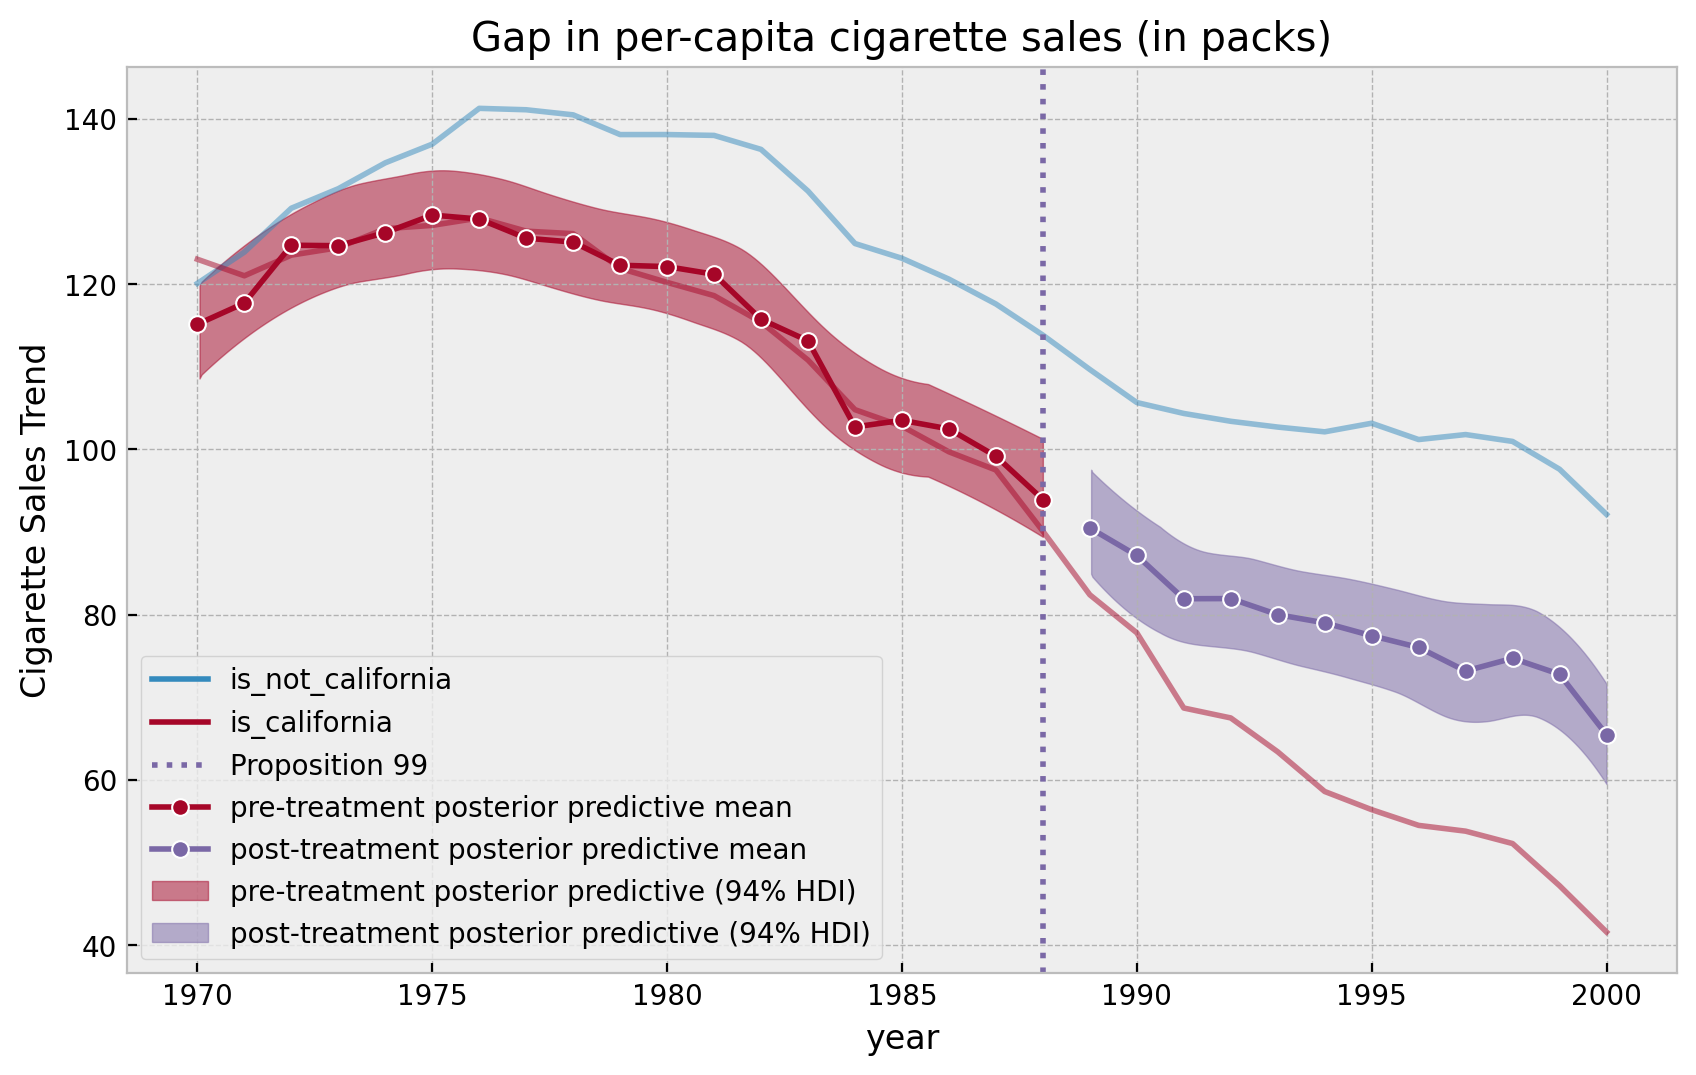

In [12]:
pre_posterior_mean = (
    posterior_predictive_pre.posterior_predictive["likelihood"][:, :, :n_pre]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)
)

post_posterior_mean = (
    posterior_predictive_post.posterior_predictive["likelihood"][:, :, :n_post]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)
)


fig, ax = plt.subplots()

(
    df.groupby(["year", "california"], as_index=False)
    .agg({"cigsale": np.mean})
    .assign(
        california=lambda x: x.california.map(
            {True: "is_california", False: "is_not_california"}
        )
    )
    .pipe(
        (sns.lineplot, "data"),
        x="year",
        y="cigsale",
        hue="california",
        alpha=0.5,
        ax=ax,
    )
)
ax.axvline(
    x=1988,
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
sns.lineplot(
    x=pre_years,
    y=pre_posterior_mean,
    color="C1",
    marker="o",
    label="pre-treatment posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=post_years,
    y=post_posterior_mean,
    color="C2",
    marker="o",
    label="post-treatment posterior predictive mean",
    ax=ax,
)
az.plot_hdi(
    x=pre_years,
    y=posterior_predictive_pre.posterior_predictive["likelihood"][:, :, :n_pre],
    smooth=True,
    color="C1",
    fill_kwargs={"label": "pre-treatment posterior predictive (94% HDI)"},
    ax=ax,
)
az.plot_hdi(
    x=post_years,
    y=posterior_predictive_post.posterior_predictive["likelihood"][:, :, :n_post],
    smooth=True,
    color="C2",
    fill_kwargs={"label": "post-treatment posterior predictive (94% HDI)"},
    ax=ax,
)
ax.legend(loc="lower left")
ax.set(
    title="Gap in per-capita cigarette sales (in packs)", ylabel="Cigarette Sales Trend"
);

We can also plot the "errors".

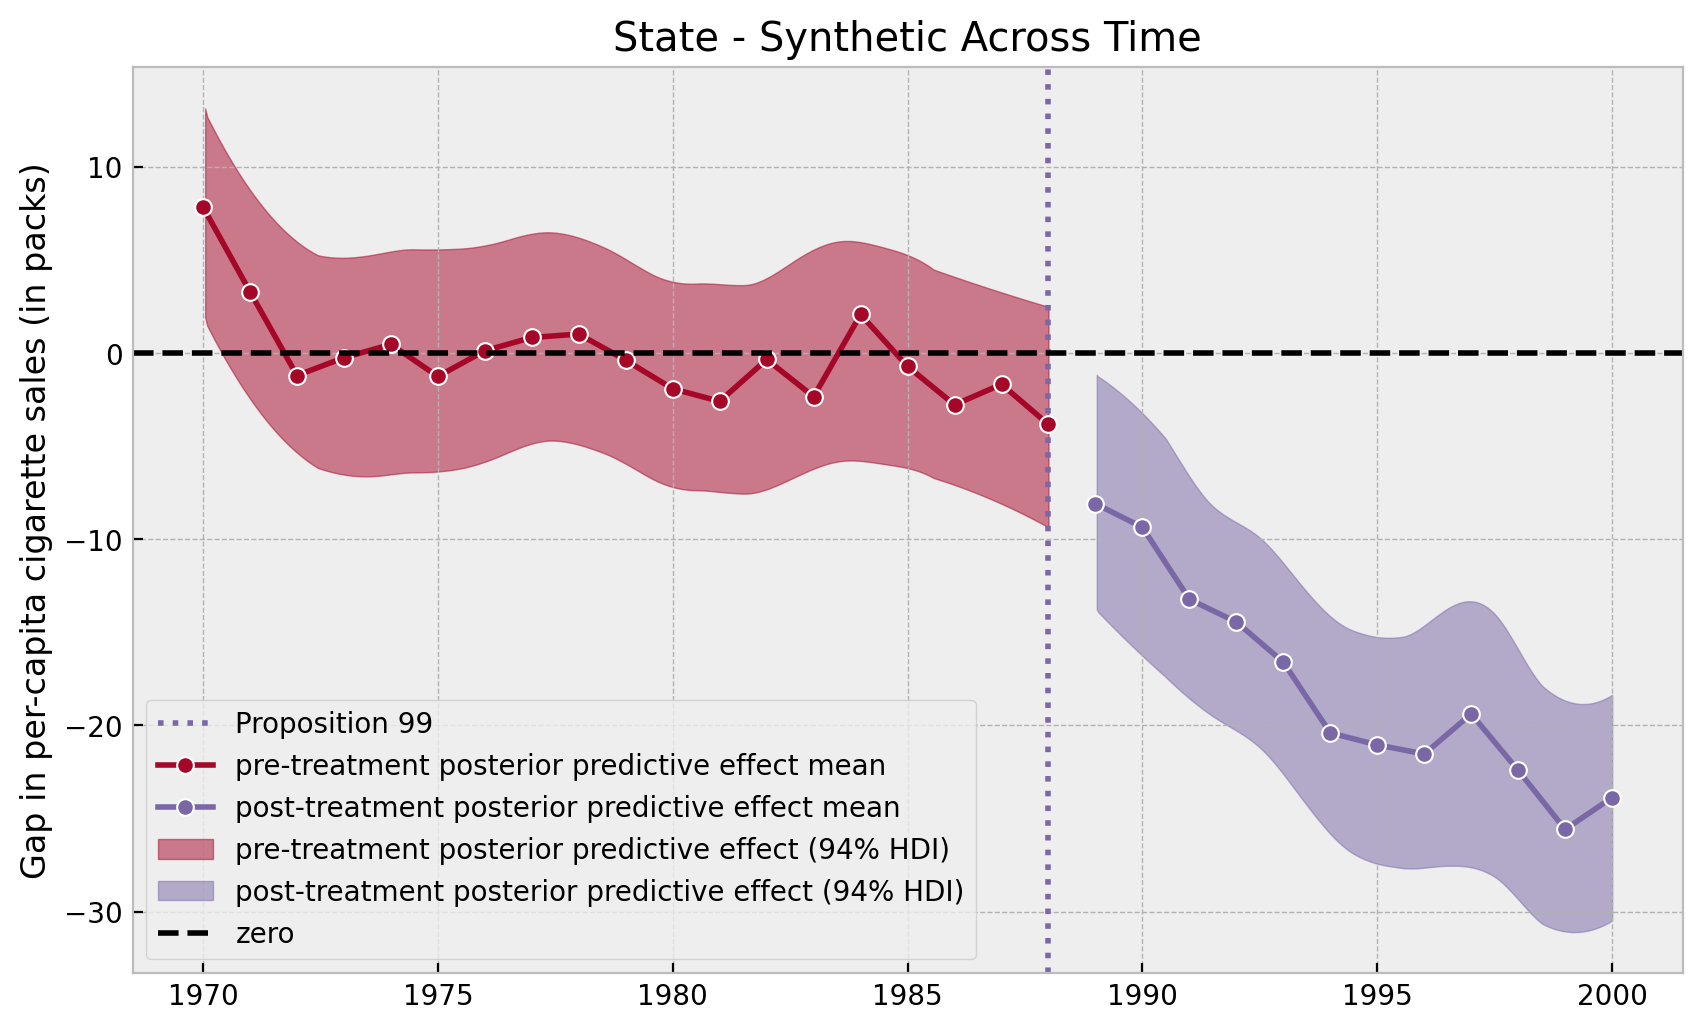

In [13]:
fig, ax = plt.subplots()

ax.axvline(
    x=1988,
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
sns.lineplot(
    x=pre_years,
    y=y_pre[:n_pre] - pre_posterior_mean,
    color="C1",
    marker="o",
    label="pre-treatment posterior predictive effect mean",
    ax=ax,
)
sns.lineplot(
    x=post_years,
    y=y_post[:n_post] - post_posterior_mean,
    color="C2",
    marker="o",
    label="post-treatment posterior predictive effect mean",
    ax=ax,
)
az.plot_hdi(
    x=pre_years,
    y=y_pre[:n_pre]
    - posterior_predictive_pre.posterior_predictive["likelihood"][:, :, :n_pre],
    smooth=True,
    color="C1",
    fill_kwargs={"label": "pre-treatment posterior predictive effect (94% HDI)"},
    ax=ax,
)
az.plot_hdi(
    x=post_years,
    y=y_post[:n_post]
    - posterior_predictive_post.posterior_predictive["likelihood"][:, :, :n_post],
    smooth=True,
    color="C2",
    fill_kwargs={"label": "post-treatment posterior predictive effect (94% HDI)"},
    ax=ax,
)
ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="lower left")
ax.set(
    title="State - Synthetic Across Time",
    ylabel="Gap in per-capita cigarette sales (in packs)",
);

Note that in the pre-treatment years the model errors oscillate around zero whereas in the post-treatment period they have a negative trend.

Finally, we can take a look into the reduced sales year distribution for the year $2000$.

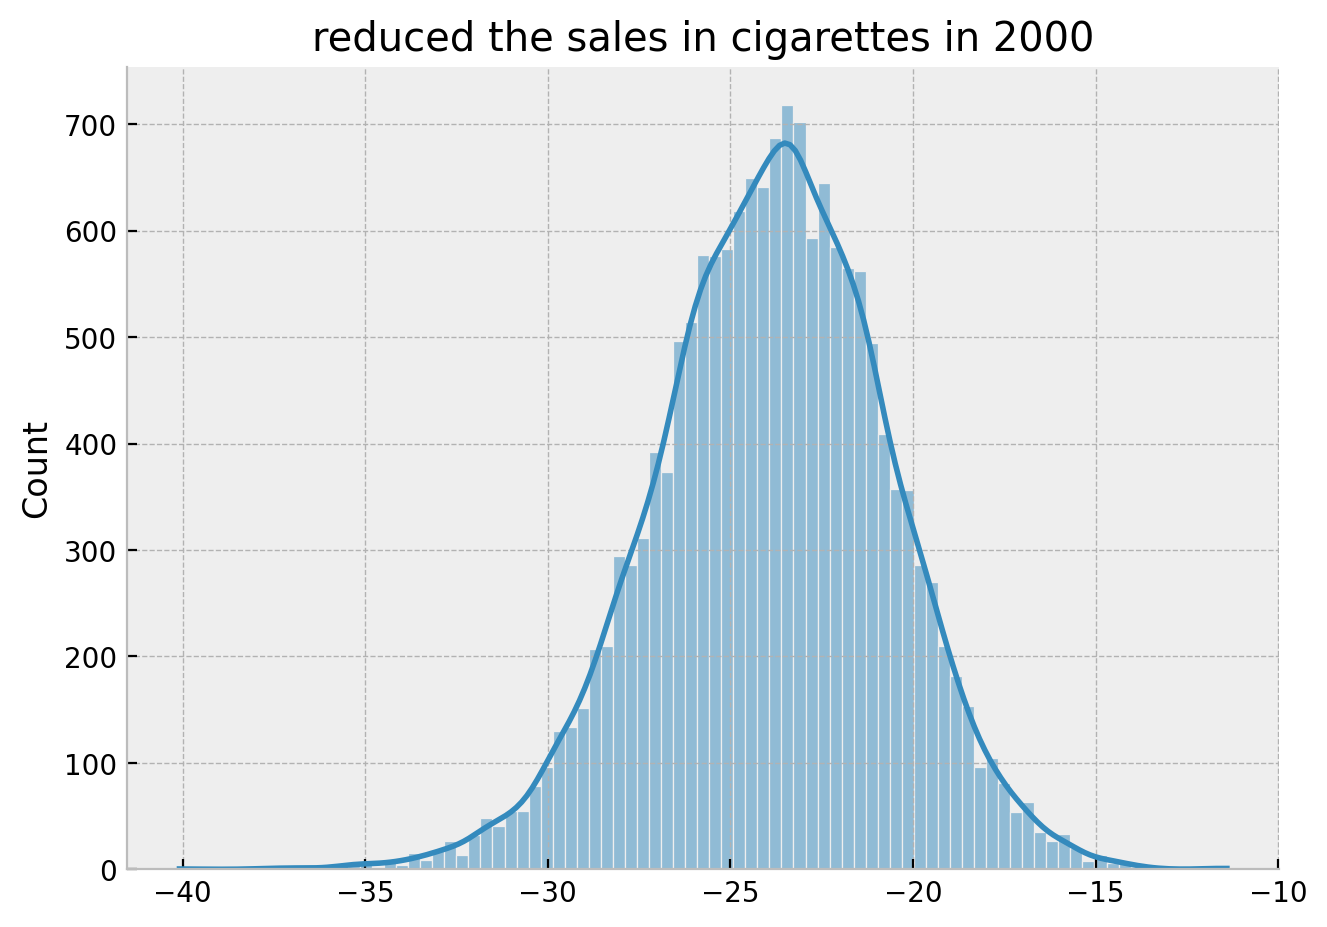

In [14]:
g = (
    (
        y_post[:n_post]
        - posterior_predictive_post.posterior_predictive["likelihood"][:, :, :n_post]
    )[:, :, -1]
    .stack(samples=("chain", "draw"))
    .pipe((sns.displot, "data"), kde=True, height=4.5, aspect=1.5)
)
g.set(title="reduced the sales in cigarettes in 2000");

Hence we obtain the same result as in the book:

> By the year 2000, it looks like Proposition 99 has reduced the sales in cigarettes by 25 packs.

However, the bayesian framework gives additional valuable information about the model's uncertainty.

## Making Inference

In this final section we want to implement the procedure described in the book to asses *significance* (see [here](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html#making-inference)). The main idea is to run the model above for all the states and compare the distribution of the resulting synthetic control estimates. First we simply write a function that wraps the main steps (its a long function which could be modularized, but I keep it explicit for the purpose of the exposition).

In [16]:
def run_synthetic_control(
    pre_df: pd.DataFrame, post_df: pd.DataFrame, idx: int
) -> tuple:
    # prepare data
    y_pre = pre_df[idx].to_numpy()
    x_pre = pre_df.drop(columns=idx).to_numpy()
    pre_years = pre_df.reset_index(inplace=False).year.unique()
    n_pre = pre_years.size

    y_post = post_df[idx].to_numpy()
    x_post = post_df.drop(columns=idx).to_numpy()
    post_years = post_df.reset_index(inplace=False).year.unique()
    n_post = post_years.size

    k = pre_df.shape[0]

    # specify the model
    with pm.Model() as model:
        x = pm.MutableData(name="x", value=x_pre)
        y = pm.MutableData(name="y", value=y_pre)

        beta = pm.Dirichlet(name="beta", a=(1 / k) * np.ones(k))
        sigma = pm.HalfNormal(name="sigma", sigma=5)
        mu = pm.Deterministic(name="mu", var=pm.math.dot(x, beta))
        likelihood = pm.Normal(name="likelihood", mu=mu, sigma=sigma, observed=y)

        # fit the model
        idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
        posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)
        # post-treatment predictive distribution
        pm.set_data(new_data={"x": x_post, "y": y_post})
        posterior_predictive_post = pm.sample_posterior_predictive(
            trace=idata, var_names=["likelihood"]
        )

        # compute errors
        error_pre = (
            y_pre[:n_pre]
            - posterior_predictive_pre.posterior_predictive["likelihood"][:, :, :n_pre]
        )
        error_post = (
            y_post[:n_post]
            - posterior_predictive_post.posterior_predictive["likelihood"][
                :, :, :n_post
            ]
        )

    return error_pre, error_post


Now we run it (it was to run 39 bayesian model but with the JAX backend it takes less than an hour in my local machine). 

In [ ]:
from tqdm.notebook import tqdm

results = {
    idx: run_synthetic_control(pre_df=pre_df, post_df=post_df, idx=idx)
    for idx in tqdm(df["state"].unique())
}


Let's plot the results. First we look into the  mean of the posterior distributions. We do ths to verify we obtain the same results as in the book (which we do!).

**Remark:** We filter out certain states on which the synthetic control does not work well in the pre-treatment period. The book filters them out using the mean squared error. Here we filter out based on the standard deviation of the error posterior distribution (not super important). 

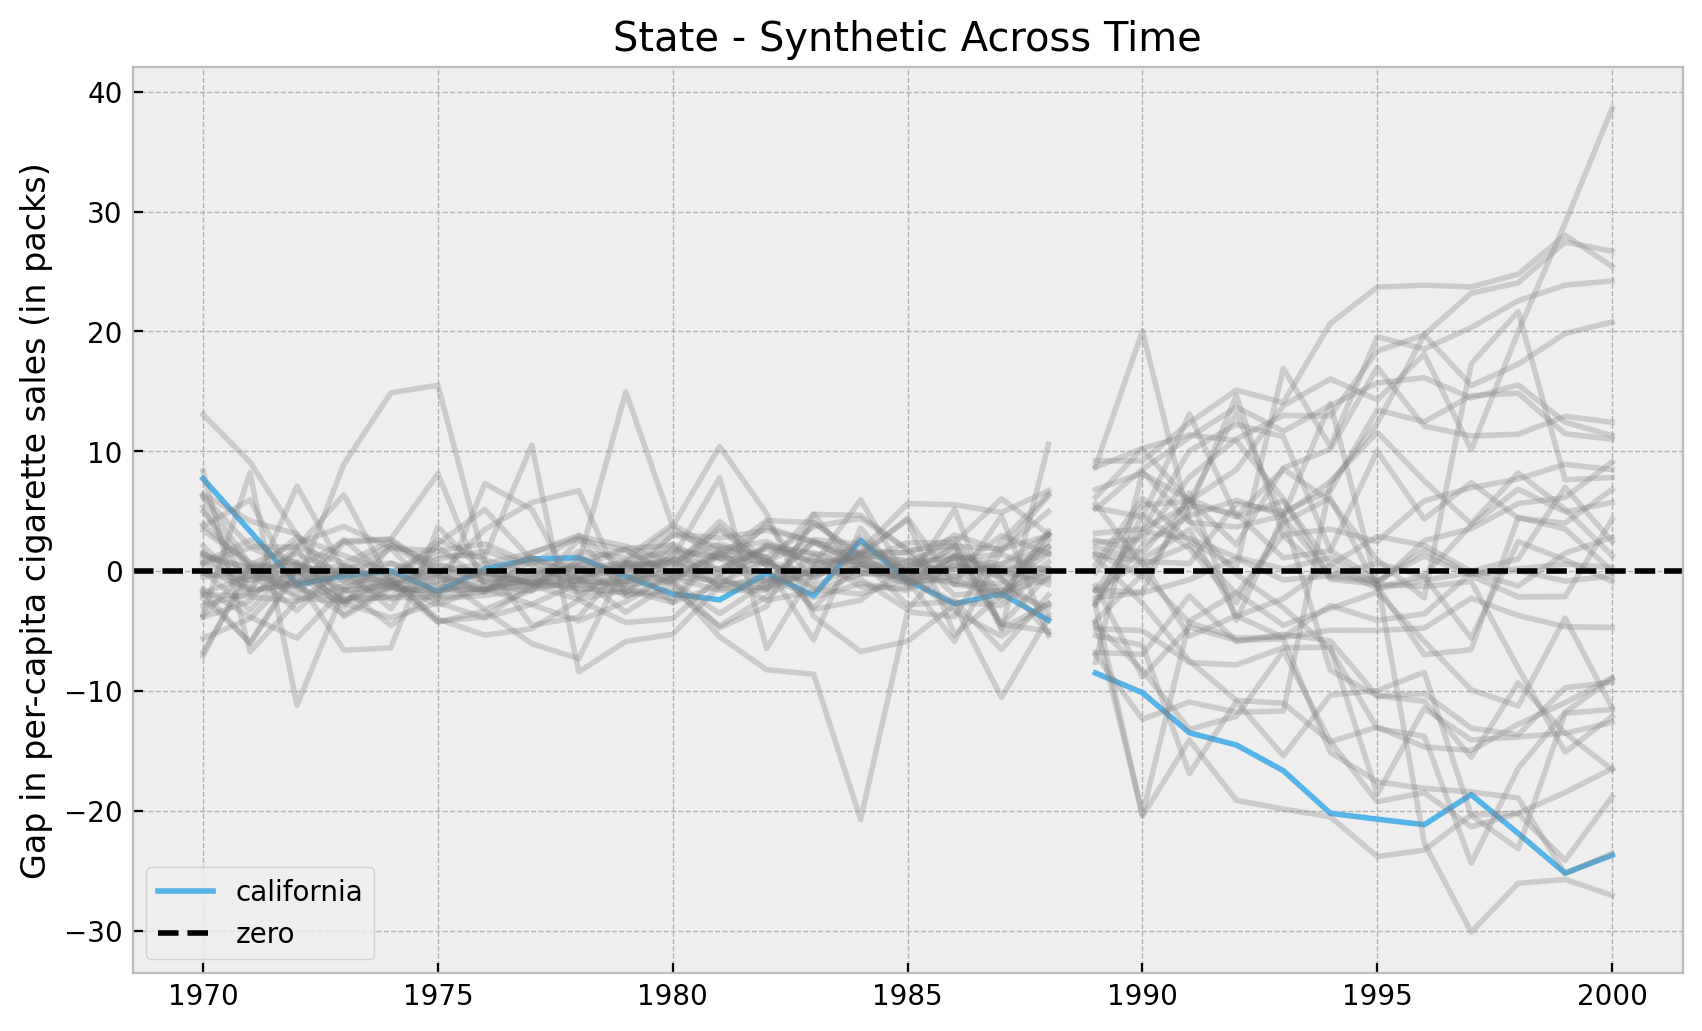

In [16]:
fig, ax = plt.subplots()

for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre < 10:
        color = "C6" if idx == 3 else "gray"
        alpha = 1 if idx == 3 else 0.3
        label = "california" if idx == 3 else None
        sns.lineplot(
            x=pre_years,
            y=error_pre.stack(samples=("chain", "draw")).mean(axis=1),
            color=color,
            alpha=alpha,
            ax=ax,
        )
        sns.lineplot(
            x=post_years,
            y=error_post.stack(samples=("chain", "draw")).mean(axis=1),
            color=color,
            alpha=alpha,
            label=label,
            ax=ax,
        )

ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="lower left")
ax.set(
    title="State - Synthetic Across Time",
    ylabel="Gap in per-capita cigarette sales (in packs)",
);

Now we can plot the whole posterior distributions.

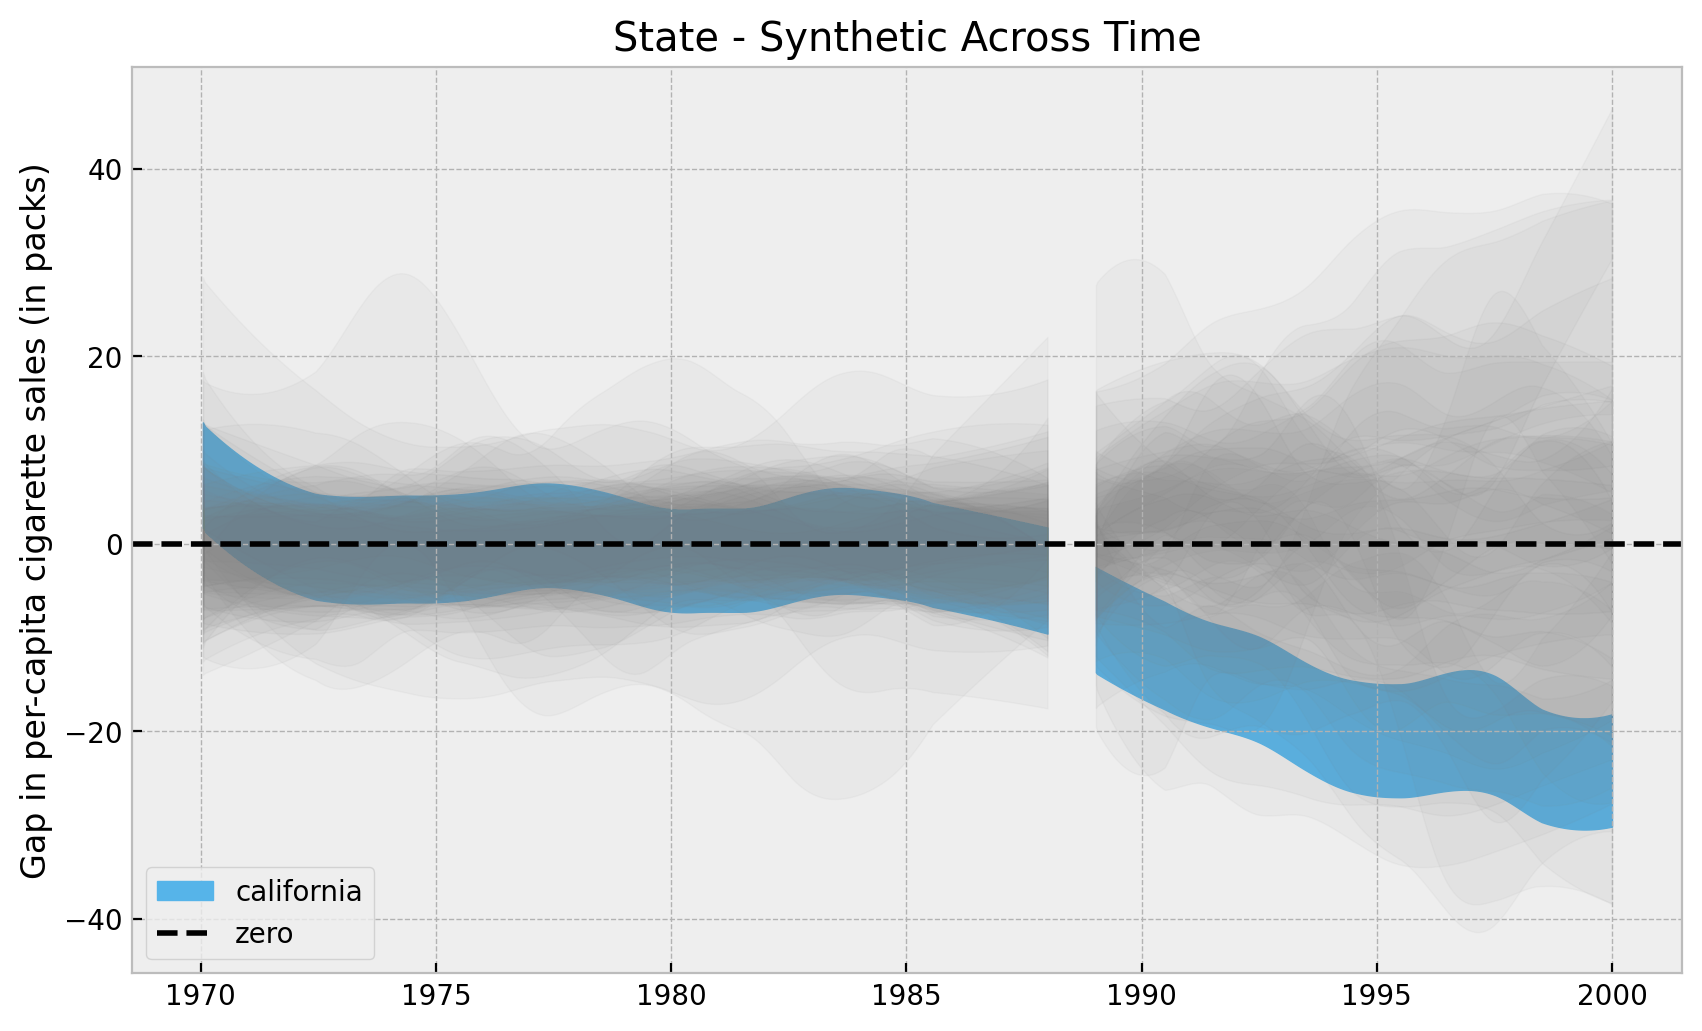

In [17]:
fig, ax = plt.subplots()

for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre < 10:
        color = "C6" if idx == 3 else "gray"
        alpha = 1 if idx == 3 else 0.05
        label = "california" if idx == 3 else None
        az.plot_hdi(
            x=pre_years,
            y=error_pre,
            smooth=True,
            color=color,
            fill_kwargs={"alpha": alpha},
            ax=ax,
        )
        az.plot_hdi(
            x=post_years,
            y=error_post,
            smooth=True,
            color=color,
            fill_kwargs={"alpha": alpha, "label": label},
            ax=ax,
        )

ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="lower left")
ax.set(
    title="State - Synthetic Across Time",
    ylabel="Gap in per-capita cigarette sales (in packs)",
);

Overall, it looks California has an "extreme" value as compared with all the other states. Let's look into the highest density intervals (HDI) for the states when looking into the year $2000$.

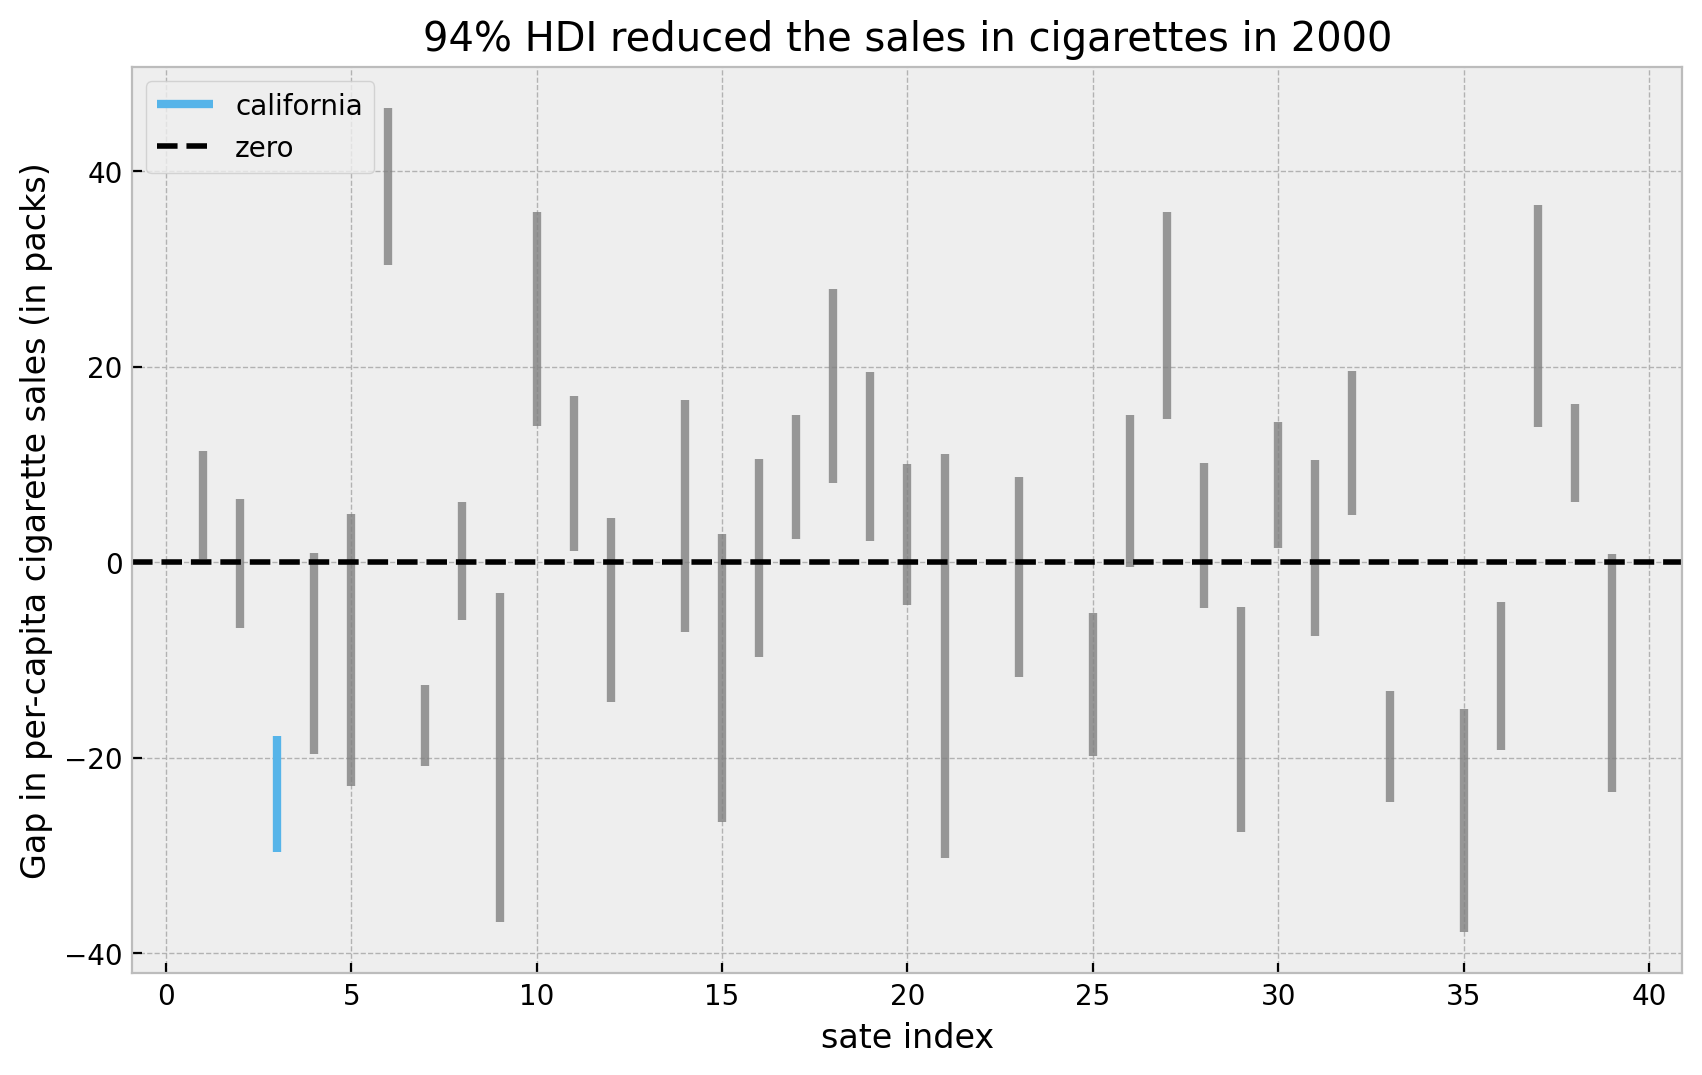

In [18]:
fig, ax = plt.subplots()

for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre < 10:
        color = "C6" if idx == 3 else "gray"
        alpha = 1 if idx == 3 else 0.8
        label = "california" if idx == 3 else None
        hdi = az.hdi(error_post[:, :, -1])["likelihood"].to_numpy()
        ax.vlines(
            x=idx,
            ymin=hdi[0],
            ymax=hdi[1],
            linestyle="solid",
            linewidth=3,
            color=color,
            alpha=alpha,
            label=label,
        )

ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="upper left")
ax.set(
    title="94% HDI reduced the sales in cigarettes in 2000",
    xlabel="sate index",
    ylabel="Gap in per-capita cigarette sales (in packs)",
);

Here we see that the HDI for California is indeed quite small an low. We can now compute *the proportion of times the effect in California is bigger than all the estimated effects.* First let is see the explicit ids of the states we are filtering out.

In [19]:
for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre >= 10:
        print(idx)

13
22
24
34


Now we "simply count":

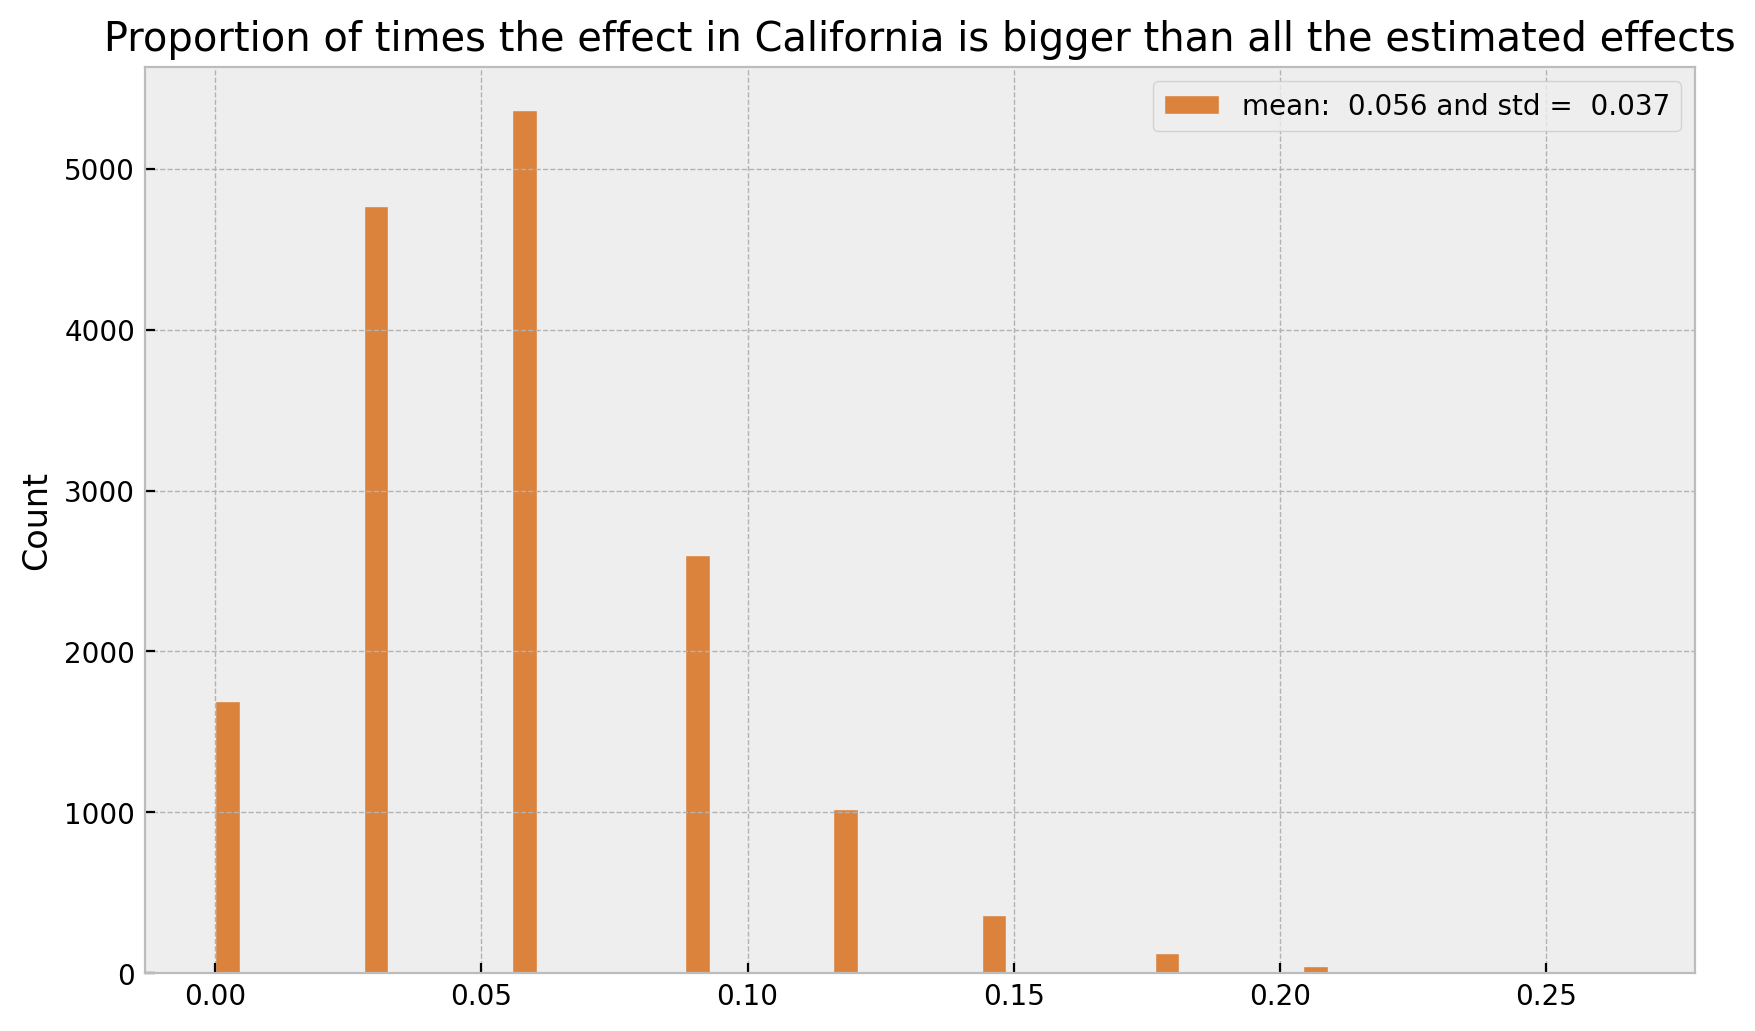

In [59]:
cal_samples = np.array(
    [
        v[1].stack(samples=("chain", "draw")).T.to_numpy()
        for k, v in results.items()
        if k == 3
    ]
)

non_cal_samples = np.array(
    [
        v[1].stack(samples=("chain", "draw")).T.to_numpy()
        for k, v in results.items()
        if k not in [3, 13, 22, 24, 34]
    ]
)


samples = (cal_samples[:, :, -1] > non_cal_samples[:, :, -1]).mean(axis=0)

fig, ax = plt.subplots()
sns.histplot(
    x=samples,
    color="C4",
    label=f"mean: {samples.mean(): .3f} and std = {samples.std(): .3f}",
    ax=ax,
)
ax.legend()
ax.set(
    title="Proportion of times the effect in California is bigger than all the estimated effects"
);

Finally, let's visualize the distributions:

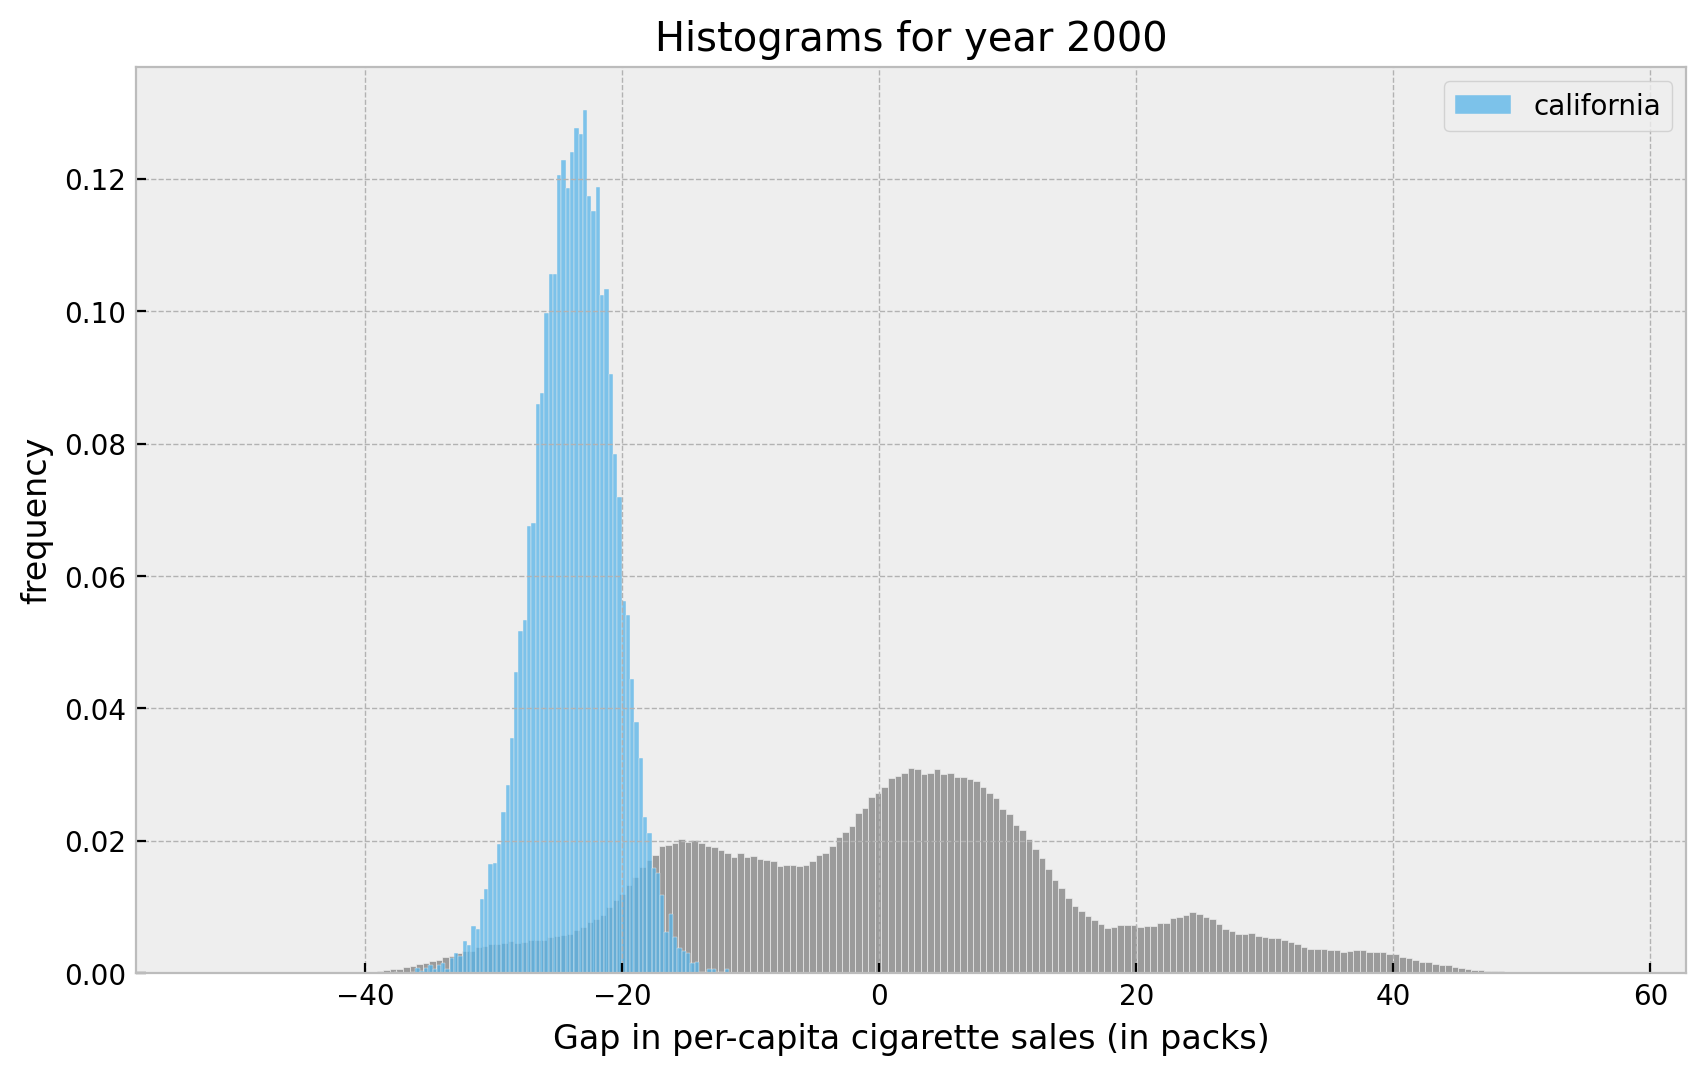

In [54]:
fig, ax = plt.subplots()
sns.histplot(x=non_cal_samples[:, :, -1].flatten(), color="gray", stat="density", ax=ax)
sns.histplot(
    x=cal_samples[:, :, -1].flatten(),
    color="C6",
    stat="density",
    label="california",
    ax=ax,
)
ax.legend(loc="upper right")
ax.set(
    title="Histograms for year 2000",
    xlabel="Gap in per-capita cigarette sales (in packs)",
    ylabel="frequency",
);

In [15]:
#import pickle

# filehandler = open("results.pkl", 'wb') 
# pickle.dump(results, filehandler)

# filehandler = open("results.pkl", 'rb') 
# results = pickle.load(filehandler)